In [402]:
#2D simulation of a wave propagating through inhomogeneous medium
import cmath
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

In [527]:
#user parameters

N=np.array([512, 1024]) # size of grid z,x
u=np.array([.1, 0.1]) #units z, x in lambda
NA=0.5 #NA of lens
RI=np.array([1.33, 1.4]) #refractive indices of turbid sample (we assume a binary RI-distribution for simplicity)

In [528]:
#creating real-space grid
x=np.arange(-N[1]/2,N[1]/2)*u[1]  #simulation window shows +/- 5 wavelengths in x
z=np.arange(0,N[0])*u[0]  #simulation window shows ~5 wavelengths in z
[X,Z]=np.meshgrid(x,z)

#creating k-space grid
uk=2*np.pi/u/N   #increment in frequency-space is 1/(size of grid in x-space); increment in k-space is 2*pi/(size of grid in x-space)
kx=np.arange(-N[1]/2,N[1]/2)*uk[1] 
kz=np.arange(0,N[0])*uk[0]
[Kx,Kz]=np.meshgrid(kx,kz)

Text(0.5,1,'RI distribution of sample')

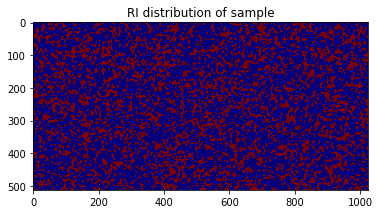

In [529]:
#defining random sample

tmp=np.random.random(N) #array of random numbers with dimensions of N

#low-pass filtering of random sample (performed in k-space)

F_tmp=np.fft.fft2(tmp)  #fourier transform random array
sigma=N/10*u  # 10% of simulation region ~ 5x10 wavelengths in real space
F_filter=np.exp(-X**2/sigma[1]**2-(Z-N[0]*u[0]/2)**2/sigma[0]**2) #Gaussian LP filter function
tmp2=np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(F_filter*F_tmp))) #apply filter, undo shift to center spectrum on zero in k space
                                                                    #2d fft back to lambda space and shift center back to zero
sample=np.fft.ifftshift((tmp2/np.max(tmp2)>0.1)*(RI[1]-RI[0])+RI[0], 1) #undo shift to center on zero for X axis, and threshold normalized values to >0.1
plt.imshow(np.real(sample),cmap='jet')   #Plot real part of filtered random refractive indices
plt.title('RI distribution of sample')


Text(0.5,0,'x')

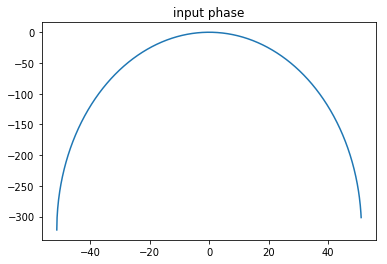

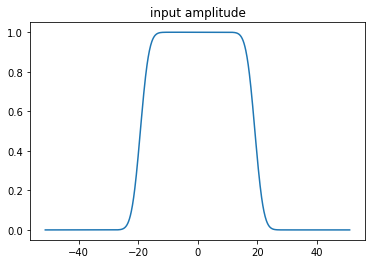

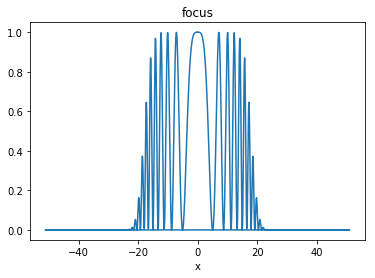

In [530]:
#defining input wavefront: a spherical, converging wave

NA_geo=NA/1.33 #geometric NA of our objective lens

# phase
R=N[0]*u[0] #radius of curvature; define it such that focus lies at last layer
phase = 2*np.pi*(np.sqrt(0j+R**2-x**2)-R)  # spherical phase

# amplitude
amp0=np.abs(x)<R*NA_geo #wave amplitude is 1 for x less than R*NA_geo, didn't know this function of the < operator
sigma_amp=1 #we filter the amplitude a bit to make the edges less sharp
amp_filter=np.exp(-x**2/sigma_amp**2)
F_amp0=np.real(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(amp0))))
amp=np.real(np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(F_amp0*amp_filter))))

plt.figure(1)
plt.plot(x,np.real(phase))
plt.title('input phase')
plt.figure(2)
plt.plot(x,amp)
plt.title('input amplitude')

E=np.zeros(N,dtype='complex') #initializing field 
E_in=np.fft.ifftshift(amp*np.exp(1j*phase))  #already apply ifftshift (loop later is faster)

plt.figure(3)
plt.plot(np.fft.fftshift(x),(np.real(E_in)**2))
plt.title('focus')
plt.xlabel('x')


In [531]:
#defining propagator for each refractive index 

RI=np.unique(sample) 
k = 2 * np.pi * RI/1.33 # k-vectors of light that traverses the different refractive indices, not accounting for objective NA here

prop = np.zeros((len(RI), N[1]), dtype='complex')  # initializing propagators
for q in range(len(RI)):
    prop[q, :] = np.fft.ifftshift(np.exp(1j * u[0] * np.sqrt(0j+k[q] ** 2 - kx ** 2)))
    
inverse_prop = np.zeros((len(RI), N[1]), dtype='complex')  # initializing propagators
for q in range(len(RI)):
    inverse_prop[q, :] = np.fft.ifftshift(np.exp(1j * u[0] * np.sqrt(0j+k[q] ** 2 - kx ** 2)))
    

In [532]:
#defining function which propagates the field through the specimen 

def fun_propagate(E_in,sample,prop):
    
    RI=np.unique(sample) #extract different RIs of sample
    N=sample.shape       #size of sample (and field)
    E=np.zeros(N,dtype='complex') #initializing field 
    Ek=np.zeros((len(RI),N[1]),dtype='complex') #init.
    mask=np.zeros((len(RI),N[0],N[1])) #initializing mask
    E[0,:]=E_in 
    
    #constructing binary masks for every RI
    for q in range(len(RI)):
        mask[q,:,:]=sample==RI[q] 
    
    #propagation loop
    for m in range(N[0]-1):
        
        for q in range(len(RI)):
            Ek[q,:]=np.fft.fft(E[m,:]*mask[q,m,:])*prop[q,:]  #for each RI: transform field to k-space and multiply with correct propagator
    
        E[m+1,:]=np.fft.ifft(sum(Ek,0)) #calculate next depth-slice of field
    
    return E

In [533]:
def correct_pupil(E_in, sample, prop, inverse_prop):
    '''apply pupil correction'''
    
    RI=np.unique(sample) #extract different RIs of sample
    N=sample.shape       #size of sample (and field)
    E0=np.zeros(N,dtype='complex') #initializing field 
    Ek0=np.zeros((len(RI),N[1]),dtype='complex') #init.
    mask0=np.zeros((len(RI),N[0],N[1])) #initializing mask
    E0[N[0]-1,:]=E_in 
    
    #constructing binary masks for every RI
    for q in range(len(RI)):
        mask0[q,:,:]=sample==RI[q] 
        
    #propagation loop1: let beam propagate from focus through the entire sample to obtain distorted E
    for m in range(N[0]-1):
        
        for q in range(len(RI)):
            Ek0[q,:]=np.fft.fft(E0[N[0]-1-m,:]*mask0[q,N[0]-m-1,:])*prop[q,:]  #for each RI: transform field to k-space and multiply with correct propagator
    
        E0[N[0]-2-m,:]=np.fft.ifft(sum(Ek0,0)) #calculate next depth-slice of field
        
    #let this distorted E propagate back to the focal plane through a clear medium
    E1 = np.zeros(N,dtype = 'complex')
    E1[0,:] = E0[0,:]
    sample1=RI[0]*np.ones(N)
    mask1=np.ones((N[0],N[1]))
    Ek1=np.zeros(N[1],dtype='complex')
    E_out = np.zeros(N,dtype = 'complex')
    phi=np.zeros(N[1],dtype='complex')
    
    for m in range(N[0]-1):
        
        Ek1[:] = np.fft.fft(E1[m,:]*mask1[m,:])*inverse_prop[0,:] # let distorted beam propagate back to the focal plane
        
        E1[m+1,:] = np.fft.ifft(Ek1)
        #take Ek1 before fourier transform to find phase at the pupil plane instead of focal plane
        E_out[m+1,:] = Ek1[:]
    for n in range(N[1]):
        phi[n] = cmath.phase(E_out[N[0]-1,n])
    return phi


Text(0.5,0,'x')

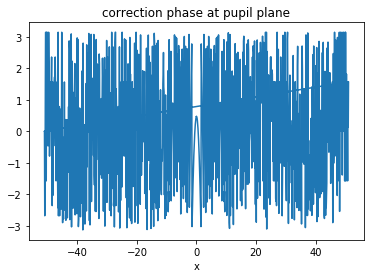

In [534]:
sample1=1.33*np.ones(N) 

E=correct_pupil(E_in, sample1, prop, inverse_prop)   #execute propagation 
    
# plt.figure(1)
# plt.imshow(np.fft.fftshift(abs(np.real(E))**2,1))
# plt.title("intensity")

# plt.figure(2)
# plt.plot(np.fft.fftshift(x),(np.real(E_test[0,:])**2))
# plt.title('E field after propagation')
# plt.xlabel('x')

plt.figure(2)
plt.plot(np.fft.fftshift(x),np.real(E))
plt.title('correction phase at pupil plane')
plt.xlabel('x')


In [573]:
def conjugated_correction(E_in, sample, prop, inverse_prop, correction_plane):
    '''apply pupil correction'''
    
    RI=np.unique(sample) #extract different RIs of sample
    N=sample.shape       #size of sample (and field)
    E0=np.zeros(N,dtype='complex') #initializing field 
    Ek0=np.zeros((len(RI),N[1]),dtype='complex') #init.
    mask0=np.zeros((len(RI),N[0],N[1])) #initializing mask
    E0[N[0]-1,:]=E_in 
    
    #constructing binary masks for every RI
    for q in range(len(RI)):
        mask0[q,:,:]=sample==RI[q] 
        
    #propagation loop1: let beam propagate from focus through the entire sample to obtain distorted E
    #Do I need to apply the inverse propagator here since the propagation direction is reversed? (I did not for now)
    for m in range(N[0]-1):
        
        for q in range(len(RI)):
            Ek0[q,:]=np.fft.fft(E0[N[0]-1-m,:]*mask0[q,N[0]-m-1,:])*prop[q,:]  #for each RI: transform field to k-space and multiply with correct propagator
    
        E0[N[0]-2-m,:]=np.fft.ifft(sum(Ek0,0)) #calculate next depth-slice of field
        
    #let this distorted E propagate back to the focal plane through a clear medium
    E1 = np.zeros((correction_plane, N[1]),dtype = 'complex')
    E1[0,:] = E0[0,:]
    mask1=np.ones((N[0],N[1]))
    Ek1=np.zeros(N[1],dtype='complex')
        
    for m in range(correction_plane-1):
        Ek1[:] = np.fft.fft(E1[m,:]*mask1[m,:])*inverse_prop[0,:] #propagate through uniform medium with RI = RI[0] to the correction plane
        
        E1[m+1,:] = np.fft.ifft(Ek1)  # phase mask of tissue wavefront distortion
    
    #next let beam propagate from focus to correction plane in clear medium 
    #(this time just start from index 0 -> correction plane instead of actually reversing the indeces because the sample is homogeneous)
    max_index = N[0]-correction_plane-1 #define maximum index in array going from focal plane to correction plane
    E2 = np.zeros((N[0]-correction_plane, N[1]), dtype = 'complex')
    E2[0,:]=E_in
    Ek2=np.zeros(N[1],dtype='complex')
       
    for m in range(max_index):
        Ek2[:] = np.fft.fft(E2[m,:]*mask1[m,:])*prop[0,:] #propagate through uniform medium with RI = RI[0] to the correction plane
        
        E2[m+1,:] = np.fft.ifft(Ek2) #distortion free propagation to correction plane
        
    #finally calculate phase difference between distorted beam (E1) and distortion free beam (E2) and apply this to corrector
    phi = np.zeros(N[1],dtype='complex')
    correction_phase = np.zeros(N[1],dtype='complex')
    for m in range(N[1]):
        phi[m] = cmath.phase(E2[max_index-1,m])
    for n in range(N[1]):
        correction_phase[n] = cmath.phase(E1[correction_plane-1,n]*np.exp(-1j*phi[n]))
    return correction_phase

Text(0.5,0,'x')

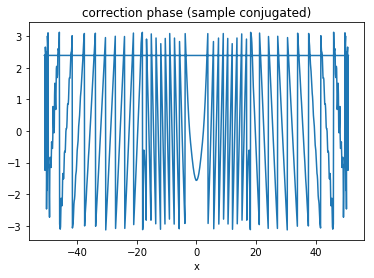

In [587]:
#first we propagate through a homogeneous sample
sample1=1.33*np.ones(N) 

phi_conjugated=conjugated_correction(E_in, sample1, prop, inverse_prop, 200)   #execute propagation 

# plt.figure(1)
# plt.imshow(np.fft.fftshift(abs(E)**2,1))
# plt.title("intensity")

plt.figure(2)
plt.plot(np.fft.fftshift(x),(np.real(phi_conjugated)))
plt.title('correction phase (sample conjugated)')
plt.xlabel('x')


Text(0.5,0,'x')

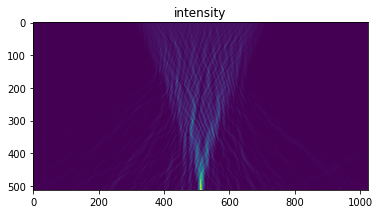

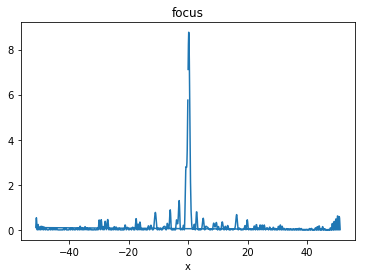

In [537]:
#now we propagate through the turbid sample 

E=fun_propagate(E_in,sample,prop)   #execute propagation 
    
plt.figure(1)
plt.imshow(np.fft.fftshift(abs(E)**2,1))
plt.title("intensity")

plt.figure(2)
plt.plot(np.fft.fftshift(x),(np.real(E[-1,:])**2))
plt.title('focus')
plt.xlabel('x')

In [538]:
def grating1D(spacing, sample):
    "Creates a grating structure with frequency 1/spacing where 'spacing' is in units of wavelength"
    grating=((x+u[1]/2) % spacing)>=spacing/2
    return grating

In [589]:
def scan(E_0, sample, grating_spacing_in, stepsize_in, FOVin):
    '''Steps beam propagated through 'sample' across grating with spacing 'grating_spacing' with a step size 'stepsize' and field of view FOV in units of wavelength.''' 
    global num_steps
    global FOV
    global grating_spacing
    global stepsize
    
    grating_spacing = grating_spacing_in
    stepsize = stepsize_in
    FOV = FOVin
    grating = grating1D(grating_spacing, sample) #create sample grating with spacing grating_spacing in units of wavelength
        
    m = int(stepsize/u[1])  #size of steps during beam scan
    num_steps = int(FOV/u[1]/m) #number of steps in image
    
    lines = np.zeros((num_steps, N[1])) #make array to hold each line of the scan 
    for q in range(num_steps):  #loop to step beam and add up intensities
        E = fun_propagate(E_0,np.roll(sample,q*m,axis=1),prop)  #calculate electric field at focus modulated by sample
        lines[q,:] = abs(E[-1,:])**4*np.roll(grating,q*m)
   
    image=np.sum(lines,1)
    return image

In [590]:
#Define corrected input fields:
#sample conjugated correction
E_sample = np.zeros(N[1], dtype = 'complex')
phi_sample = conjugated_correction(E_in, sample1, prop, inverse_prop, 200)
E_sample = E_in*np.exp(1j*phi_sample)
#pupil conjugated correction
E_pupil = np.zeros(N[1], dtype = 'complex')
phi_pupil = correct_pupil(E_in, sample1, prop, inverse_prop)
E_pupil = E_in*np.exp(1j*phi_pupil)

image_pure = scan(E_in, sample1, 2, 0.5, 20)
image_aberrated = scan(E_in, sample, 2, 0.5, 20)

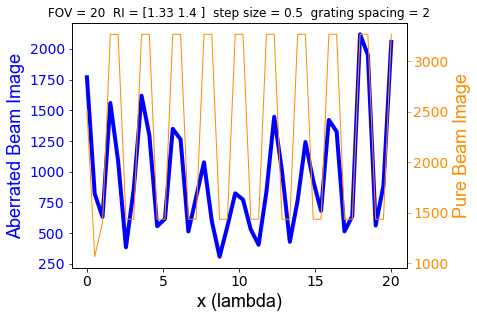

In [586]:
xnew = np.linspace(0, FOV, num_steps)

fig, ax1 = plt.subplots(1,1,figsize=(6,4.5))
ax1.plot(xnew, image_aberrated, 'b', linewidth = 4)
ax1.set_ylabel('Aberrated Beam Image', color='b', fontsize =18, fontname = 'Arial')
ax1.tick_params('y', colors='b', labelsize = 14)
ax1.yaxis.set_label_position("left")
ax2 = ax1.twinx()
ax2.plot(xnew ,image_pure, 'darkorange', linestyle="-", linewidth = 1)
ax2.set_ylabel('Pure Beam Image', color='darkorange', fontsize = 18, fontname = 'Arial')
ax2.tick_params('y', colors='darkorange', labelsize = 14)
plt.title('FOV = ' + str(FOV) + '  RI = ' + str(RI) + '  step size = ' + str(stepsize) + '  grating spacing = ' + str(grating_spacing))
ax1.set_xlabel('x (lambda)', fontsize = 18, fontname = 'Arial')
ax1.tick_params('x', colors='k', labelsize = 14)